# Good-looking Elevation Graphing
The point of this project is to make simplified but useful elevation graphs. This will also combine multiple rides into a single elevation profile.

Point the notebook to the file the gpx files are sitting in

In [15]:
my_folder = ''

We import some librarys that we need

In [44]:
import os
import pandas as pd
import numpy as np
import gpxpy as gp
from gpxpy.geo import distance
import matplotlib.pyplot as plt

First we choose which files to read. The defualt is to read every gpx in the folder specified, but you can also provide a list of the files you want to read

In [12]:
data_files = [] # populate this list if you want to specify only certain files in the folder

In [16]:
if len(data_files) == 0:
    data_files = os.listdir(my_folder)

In [81]:
gpx_files = list()
for file in data_files:
    gpx_file = open(my_folder + '/' + file, 'r')
    gpx_files.append(gp.parse(gpx_file))

In [111]:
temp_data = list()
for gpx in gpx_files:
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                temp_data.append([point.time, point.latitude, point.longitude, point.elevation])

In [120]:
total_data = pd.DataFrame(temp_data, columns=['time', 'lat', 'lon', 'ele'])
total_data['date'] = total_data['time'].dt.date
total_data = total_data.sort_values(by=['time'])

# Calculate distance
temp_dist = [0]
temp_ele = [0]
for (ix1, row1), (ix2, row2) in zip(total_data.iloc[:-1].iterrows(), total_data.iloc[1:].iterrows()):
    temp_dist.append(distance(
                        latitude_1=row1['lat'],
                        longitude_1=row1['lon'], 
                        elevation_1=None,
                        latitude_2=row2['lat'],
                        longitude_2=row2['lon'], 
                        elevation_2=None))
    temp_ele.append(row2['ele'] - row1['ele'])

total_data['dist'] = temp_dist
total_data['ele_delta'] = temp_ele

total_data.head()

,time,lat,lon,ele,date,dist,ele_delta
33816,2022-07-10 09:03:59+00:00,47.592552,12.180832,491.1,2022-07-10,0.000000,0.0
33817,2022-07-10 09:04:00+00:00,47.592548,12.180844,491.2,2022-07-10,1.004920,0.1
33818,2022-07-10 09:04:01+00:00,47.592545,12.180855,491.2,2022-07-10,0.890781,0.0
33819,2022-07-10 09:04:02+00:00,47.592544,12.180858,491.2,2022-07-10,0.251230,0.0
33820,2022-07-10 09:04:03+00:00,47.592542,12.180862,491.2,2022-07-10,0.373825,0.0


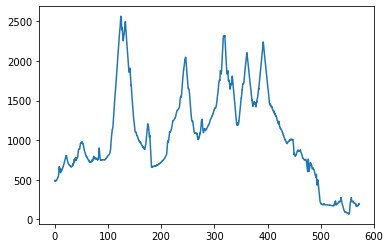

In [121]:
#find unique dates
day = 19
dates = total_data['date'].unique()
# pd.options.mode.chained_assignment = None

un_day = total_data[total_data['date'].isin(dates[:])]
un_day['CumDist'] = un_day['dist'].cumsum()
un_day

plt.plot(un_day['CumDist'] / 1000, un_day['ele'])
plt.show()

A simple rolling average with radius of x metres, and fill in the gaps using linear interpolation

(571,)


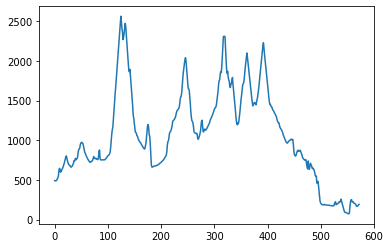

In [122]:
x = 1000 #rolling average across points within x metres

day_dist = un_day['CumDist'].max()

nodes = int(day_dist / x)

points = np.linspace(0, day_dist, num=nodes)
hold_ave = np.zeros(nodes)

idx = 0
for d in points:
  #filter dataframe to find elevations in distance bound
  dist_band = un_day[(un_day['CumDist'] > d - x / 2) & (un_day['CumDist'] <= d + x / 2)]
  hold_ave[idx] = dist_band['ele'].mean()
  if idx == 0:
    hold_ave[idx] = un_day['ele'].iloc[0]
  idx += 1

#linear interpolation
for i in range(hold_ave.shape[0]):
  fwd = 1
  if not(np.isnan(hold_ave[i])):
    prev_num = hold_ave[i]
  else:
    while  np.isnan(hold_ave[i + fwd]):
      fwd += 1

    end_num = hold_ave[i + fwd]
    delta = (end_num - prev_num) / fwd

    hold_ave[i] = prev_num + delta

print(hold_ave.shape)
plt.plot(points / 1000, hold_ave)
plt.show()



To smooth out the sharp corners we will now appoximate these graphs with a polynomial

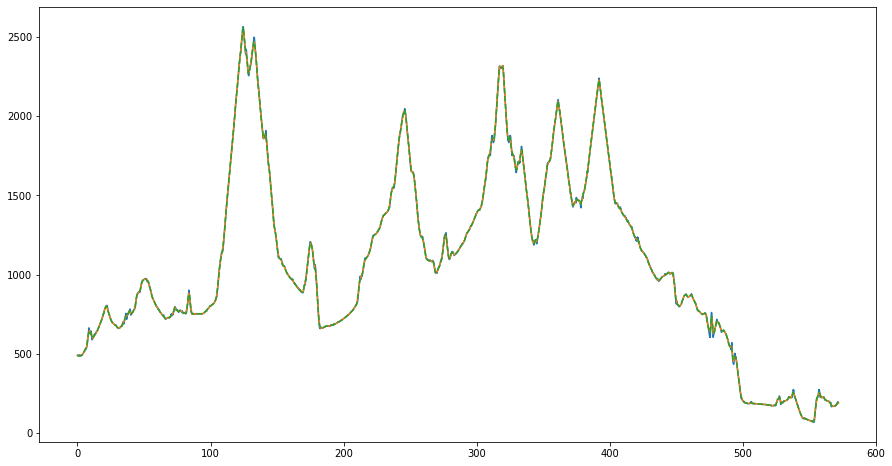

In [123]:
from scipy import interpolate as it

new_x = np.linspace(0, day_dist, 500)

smooth_ave = it.InterpolatedUnivariateSpline(points, hold_ave)
sm = smooth_ave(new_x)

fig, ax = plt.subplots(figsize=(15, 8))

plt.plot(un_day['CumDist'] / 1000, un_day['ele'])
ax.plot(new_x/1000, sm)
ax.plot(points/1000, hold_ave, linestyle='dashed')
plt.show()

We only want to pick the max points at local maxima/minima, where this local variation in height is significant. To do this we need to identify these maxima/minima, and select if these are significant variations. If the point is not a maxima/minima, we take the average.

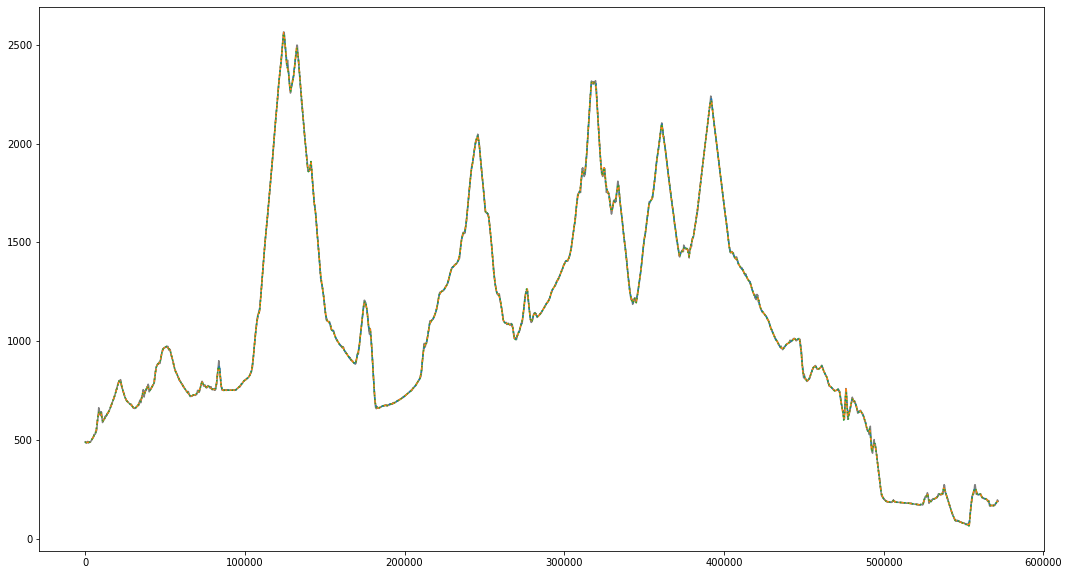

In [124]:
#look for areas that are +-x metres from average in original data
edit_arr = np.copy(hold_ave)
diff = 10

count = 0
for d in points[1:-1]:
  #find value of before and after point
  try:
    id1, id2 = un_day[un_day['CumDist'] <= d]['CumDist'].idxmax(), un_day[un_day['CumDist'] > d]['CumDist'].idxmin()

    x1, x2 = un_day['CumDist'].loc[id1], un_day['CumDist'].loc[id2]
    y1, y2 = un_day['ele'].loc[id1], un_day['ele'].loc[id2]

    new_h = (y2 - y1) / (x2 - x1) * (d - x1) + y1

    count += 1
    id_arr = np.where(points == d)
    if abs(new_h - hold_ave[id_arr]) > diff:
      edit_arr[id_arr] = new_h
  except:
    print('Nope')
smoother = it.InterpolatedUnivariateSpline(points, edit_arr)
new_x = np.linspace(0, day_dist, 1000)
sm = smoother(new_x)

fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(un_day['CumDist'], un_day['ele'], color='grey')

ax.plot(points, hold_ave, linestyle='dashed')
ax.plot(points, edit_arr, linestyle='dashed')
ax.plot(new_x, sm, linestyle=':')
plt.show()

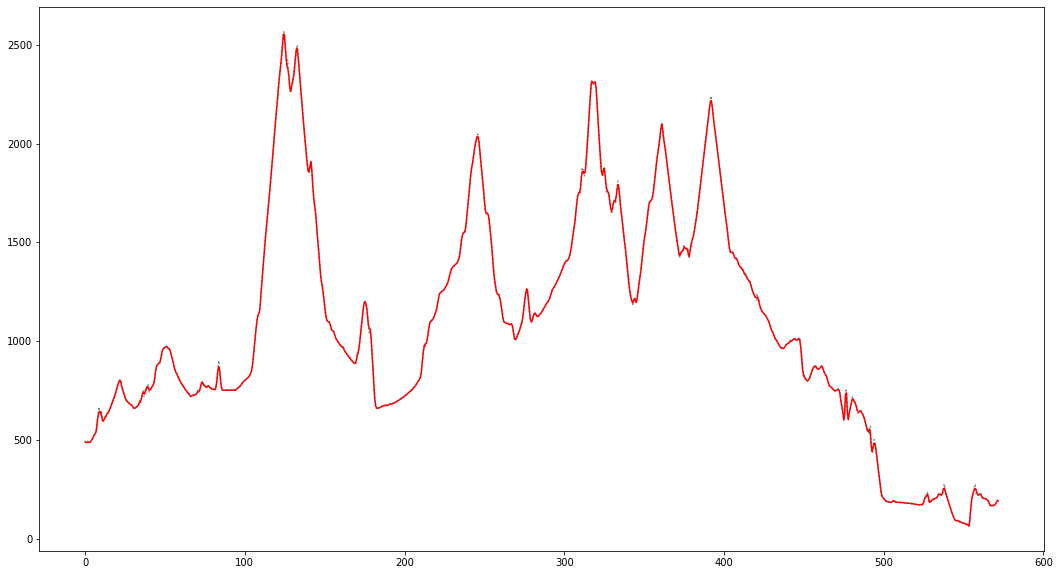

In [125]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(un_day['CumDist']/1000, un_day['ele'], linestyle=':', color='grey')
ax.plot(new_x/1000, sm, color='r')
plt.show()

We want to find cumulative climbing done

In [126]:
un_day['date'] = pd.to_datetime(un_day['date'])

In [127]:
unique_dates = un_day['date'].dt.date.unique()

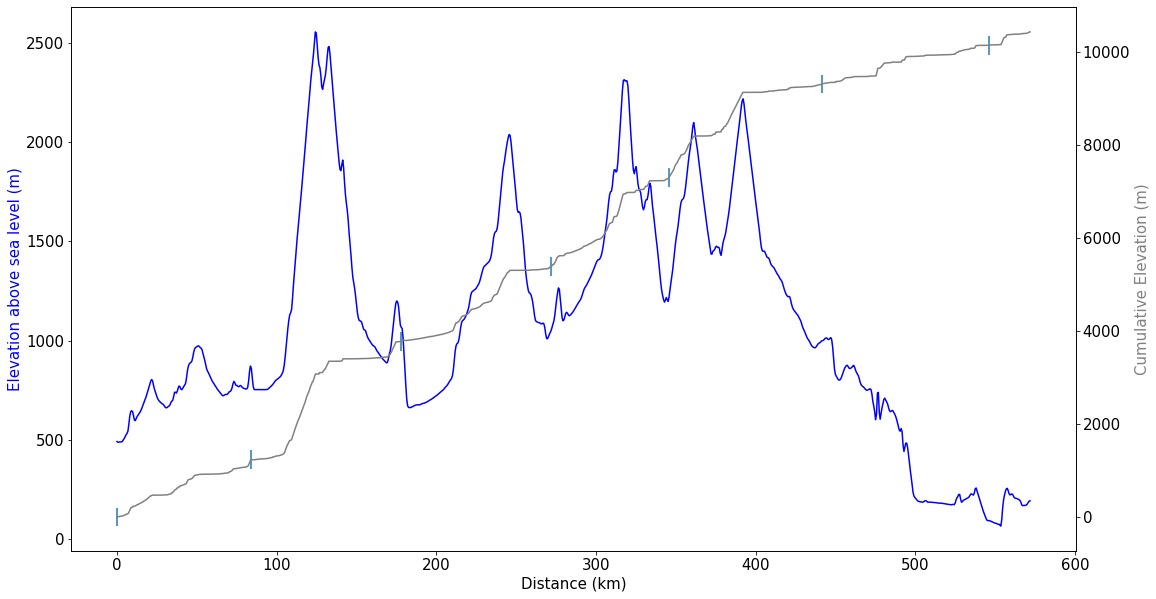

In [128]:
# un_day['EleDelta'] = (un_day['EndEle'] - un_day['ele'])

clm = np.empty(len(un_day))
clm[0] = un_day['ele_delta'].iloc[0] if un_day['ele_delta'].iloc[0] > 0 else 0
for i in range(1, len(un_day)):
  if un_day['ele_delta'].iloc[i] > 0:
    clm[i] = clm[i - 1] + un_day['ele_delta'].iloc[i]
  else:
    clm[i] = clm[i - 1]

un_day['CumEle'] = clm - clm[0]

clm2 = np.empty(sm.shape[0])
clm2[0] = 0
for i in range(1, sm.shape[0]):
  if (sm[i] - sm[i - 1]) > 0:
    clm2[i] = clm2[i - 1] + (sm[i] - sm[i - 1])
  else:
    clm2[i] = clm2[i - 1]

fig, ax1 = plt.subplots(figsize=(18, 10))

ax2 = ax1.twinx()

plt_cl = "blue"

for d in unique_dates:
  dlta = 200
  dist = un_day[un_day['date'].dt.date == d]['CumDist'].min()
  cum_ele = un_day[un_day['CumDist'] == dist]['CumEle']
  ax2.vlines(dist/1000, cum_ele - dlta, cum_ele + dlta)

ax1.plot(new_x/1000, sm, color=plt_cl, label='Actual Elevation')
ax2.plot((un_day['CumDist'])/1000, un_day['CumEle'], color='grey', label='Cumulative Climbing')

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax1.set_xlabel('Distance (km)', size=15)
ax1.set_ylabel('Elevation above sea level (m)', c=plt_cl, size=15)
ax2.set_ylabel('Cumulative Elevation (m)', c='grey', size=15)

plt.show()

Save Image

In [ ]:
saveloc = ''

fig.savefig(saveloc, dpi=600)